In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skbio.stats import subsample_counts
from skbio.stats.composition import ancom
from skbio.stats.distance import permanova, mantel
from skbio.stats.composition import ancom, closure, clr
from skbio import TreeNode
import biom
from scipy.stats import mannwhitneyu, ttest_ind

%matplotlib inline

In [2]:
map_fp = '../data/Payami_parkinsons_qiime_mapping_corrected_drugs_spouse.txt'
map_ = pd.read_csv(map_fp, 
                   sep='\t',
                   dtype=str, 
                   encoding = "ISO-8859-1",
                   na_values=['NA', 'Not applicable', 'not applicable', "Don't Know"]
                   )
map_.set_index('#SampleID', inplace=True) 

In [3]:
def exploding_panda(_bt):
    """BIOM->Pandas dataframe converter

    Parameters
    ----------
    _bt : biom.Table
        BIOM table

    Returns
    -------
    pandas.DataFrame
        The BIOM table converted into a DataFrame
        object.

    References
    ----------
    Based on this answer on SO:
    http://stackoverflow.com/a/17819427/379593
    
    Function written by Yoshiki Vazquez Baeza 
    (from https://github.com/biocore/biom-format/issues/622)
    """
    m = _bt.matrix_data
    data = [pd.SparseSeries(m[i].toarray().ravel()) for i in np.arange(m.shape[0])]
    out = pd.SparseDataFrame(data, index=_bt.ids('observation'),
                             columns=_bt.ids('sample'))

    return out

In [27]:
#otu_biom = biom.load_table('../data/337_otu_table.biom')
otu_biom = biom.load_table('../data/filtered_otu_5k.biom')
otu_ = exploding_panda(otu_biom).to_dense().T
otu_ = otu_.astype(np.int)

In [22]:
map_fp = '../data/Payami_parkinsons_qiime_mapping_corrected_drugs_spouse.txt'
map_ = pd.read_csv(map_fp, 
                   sep='\t',
                   dtype=str, 
                   encoding = "ISO-8859-1",
                   na_values=['NA', 'Not applicable', 'not applicable', "Don't Know"]
                   )
map_.set_index('#SampleID', inplace=True)

In [23]:
map_ = map_.dropna(subset=['case_control'])

Perform rarefaction

In [28]:
#otu_ = otu_.loc[otu_.sum(axis=1)>5000, :]
#otu_ = otu_.apply(lambda x: subsample_counts(x, n=5000), axis=1)
otu_ = otu_.loc[:, (otu_ > 0).sum(0) > 0.1*len(map_.index)].astype(float)
otu_ = otu_.loc[:, otu_.sum(axis=0)>0] 
# drop the bloody contaminant
#otu_ = otu_.drop('4448331', 1)

In [29]:
# Defines the samples to filter
keep_samples = (set(map_.index).intersection(set(otu_.index)) - 
                {'10122.BLANK.1.1A', '10122.BLANK.3.3C', '10122.BLANK.4.12H', 
                 '10122.BLANK.4.4E'})

In [30]:
# Filters the map and distance matrices
map_ = map_.loc[keep_samples]
otu_ = otu_.loc[map_.index]

In [31]:
# Next we convert the whole thing to porportions
otu_props = pd.DataFrame(closure(otu_.values + 1),
                         index=otu_.index,
                         columns=otu_.columns)

In [32]:
otu_.shape

(322, 684)

In [33]:
res = ancom(otu_props, map_.case_control)

In [34]:
res.loc[res.reject]

W reject
4465907  676   True
4439469  628   True
4457438  673   True
4365130  633   True
4481131  653   True
4481427  661   True
4392188  655   True
173969   635   True
180999   639   True
4381430  661   True
4347159  650   True
4416570  633   True

In [35]:
res.loc[res.reject].shape

(12, 2)

In [36]:
ids = list(map(str, [4465907, 4457438, 4381430, 4481427, 4481131, 4392188, 4347159, 180999,
           4325096, 4365130, 4439469, 173969, 176306, 4352657, 4416570, 505670]))

In [37]:
set(res.loc[res.reject].index) - set(ids) 

set()

In [70]:
myu_pval = lambda x: -np.log(mannwhitneyu(x[map_.case_control=='Case'], x[map_.case_control=='Control']))[1]
fchange = lambda x: x[map_.case_control=='Case'].mean() - x[map_.case_control=='Control'].mean()

#pvals = otu_.apply(myu_pval, axis=0)
pvals = res.W
clrotu_ = otu_.apply(lambda x: clr(x+1), axis=1)
fold_change = clrotu_.apply(fchange, axis=0)

In [71]:
fold_change.loc[ids].values

array([-0.93654257, -1.01698748, -0.84213579, -0.76306455, -0.80853684,
       -0.74939508,  0.71464083, -0.57228531, -0.54292824,  0.72476025,
        0.63653652, -0.60333606, -0.48072441, -0.50876885, -0.61134044,
        0.54256862])

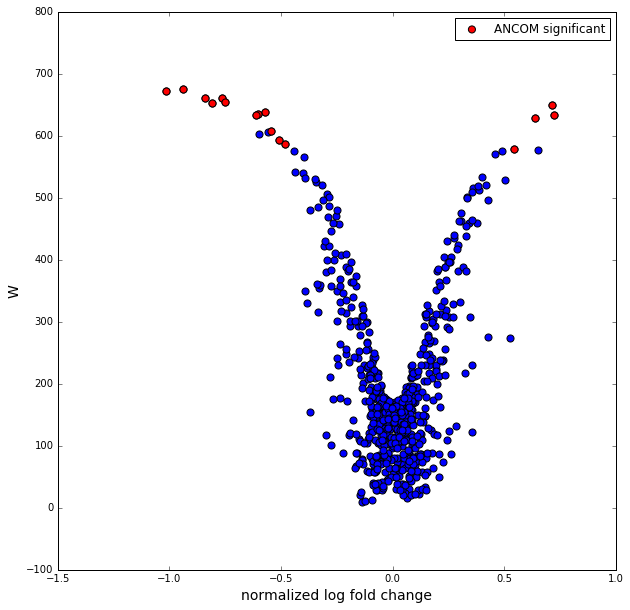

In [75]:
plt.figure(figsize=(10, 10))
plt.scatter(fold_change.values, pvals.values, s=50)
plt.scatter(fold_change.loc[ids].values, pvals.loc[ids].values, c='r', s=50, label='ANCOM significant')
#plt.ylim([0, 20])
plt.ylabel('W', fontsize=14)
plt.xlabel('normalized log fold change', fontsize=14)
plt.legend(scatterpoints=1)
plt.savefig('../results/volcano_plot.png')